In [56]:
!python --version

Python 3.9.20


In [57]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Désactive le GPU et utilise le CPU uniquement car pas de GPU


In [58]:
import tensorflow as tf
import skimage
import tensorflow.keras as keras

print("TensorFlow version:", tf.__version__)
print("scikit-image version:", skimage.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.18.0
scikit-image version: 0.24.0
Keras version: 3.6.0


In [59]:

# List available GPUs
# gpus = tf.GPUOptions()

# Check for available devices
gpu_devices = tf.config.list_physical_devices('GPU') if hasattr(tf, 'config') else tf.test.gpu_device_name()

# Print the number of available GPUs
if gpu_devices:
    print("Num GPUs Available: ", len(gpu_devices))
else:
    print("No GPUs available")


No GPUs available


In [60]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [61]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "/Users/Zaineb/Documents/Workspace/AI/Glasses Or No Glasses"
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [62]:
from mrcnn.config import Config

class GlassesConfig(Config):
    NAME = "glasses_detection"
    GPU_COUNT = 1  # Pas de GPU
    IMAGES_PER_GPU = 1  # Une image à la fois sur le CPU
    NUM_CLASSES = 1 + 1  # Background + classes "drone"
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    CLASS_NAMES = ["bg", "glasses"]
    IMAGE_MAX_DIM = 512

config = GlassesConfig()

In [63]:
import os
import json
import numpy as np
from skimage.io import imread
from mrcnn.utils import Dataset
from sklearn.model_selection import train_test_split
from skimage.draw import polygon as draw_polygon

class GlassesDataset(Dataset):
    def load_glasses(self, dataset_dir, subset):
        # Add a single class for "glasses"
        self.add_class("glasses", 1, "glasses")
        
        # Define the directory for this subset (train/validation/test)
        subset_dir = os.path.join(dataset_dir, subset)
        
        # Define and check image and annotation directories
        image_dir = os.path.join(subset_dir, "images")
        annotation_dir = os.path.join(subset_dir, "annotations")
        
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not os.path.exists(annotation_dir):
            raise FileNotFoundError(f"Annotation directory not found: {annotation_dir}")
        
        # List all image files in the subset directory
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))]
        
        # Initialize an empty list to hold all annotations
        annotations = []

        # Iterate through image files and corresponding annotations
        for image_file in image_files:
            # Full path to image
            image_path = os.path.join(image_dir, image_file)

            # Extract the image ID (without file extension)
            image_id = os.path.splitext(image_file)[0]

            # Load the corresponding annotation JSON file
            annotation_path = os.path.join(annotation_dir, f"{image_id}.json")
            
            if not os.path.exists(annotation_path):
                print(f"Warning: Annotation file not found for {image_file}")
                continue
            
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)

            # Append the annotation to the annotations list
            annotations.append(annotation)

            # Extract image dimensions and annotations
            width = annotation['imageWidth']
            height = annotation['imageHeight']
            polygons = annotation['shapes']  # Modify based on actual format in your annotation file

            # Add the image and its annotations to the dataset
            self.add_image(
                "glasses",
                image_id=image_id,  # Use image file name (without extension) as the image_id
                path=image_path,
                width=width,
                height=height,
                annotations=polygons  # Pass the loaded annotations
            )

        # Split dataset if it's for training
        if subset == "train":
            train_anns, val_anns = train_test_split(annotations, test_size=0.2, random_state=42)
            annotations = train_anns
        elif subset == "val":
            _, annotations = train_test_split(annotations, test_size=0.2, random_state=42)

    def load_mask(self, image_index):
        """Generate instance masks for an image.
        Args:
            image_index: Index of the image to load.
        Returns:
            masks: A 3D array [height, width, instance count] with a binary mask per instance.
            class_ids: A 1D array of class IDs corresponding to the instances.
            bboxes: A list of bounding boxes for each mask.
        """
        # Get image info
        info = self.image_info[image_id]
        annotations = info['annotations']

        # Height and width of the image
        height = info['height']
        width = info['width']

        # Initialize mask array: one binary mask per instance
        masks = np.zeros([height, width, len(annotations)], dtype=np.uint8)

        # Class IDs array (we only have one class, "drone")
        class_ids = np.ones([len(annotations)], dtype=np.int32)

        # List to hold bounding boxes
        bboxes = []

        # Loop over each annotation (polygon or mask)
        for i, annotation in enumerate(annotations):
            # Get the polygon points for the object
            polygon = annotation['points']  # Modify based on your annotation file structure

            # Convert polygon to a binary mask using the class method
            mask = self.polygon_to_mask(polygon, height, width)
            masks[:, :, i] = mask  # Assign the binary mask for the object

            # Get bounding box
            x_min = min(p[0] for p in polygon)
            y_min = min(p[1] for p in polygon)
            x_max = max(p[0] for p in polygon)
            y_max = max(p[1] for p in polygon)
            bboxes.append([y_min, x_min, y_max, x_max])

        return masks, class_ids

    def polygon_to_mask(self, polygon, height, width):
        """Helper function to convert a polygon into a binary mask.
        Args:
            polygon: List of polygon points in [(x1, y1), (x2, y2), ...] format.
            height, width: Dimensions of the mask.
        Returns:
            mask: A binary mask with the polygon area set to 1.
        """
        # Create an empty mask
        mask = np.zeros((height, width), dtype=np.uint8)

        # Separate x and y coordinates from the polygon points
        poly_x = [p[0] for p in polygon]
        poly_y = [p[1] for p in polygon]

        # Draw the polygon on the mask
        rr, cc = draw_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1

        return mask


In [64]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/Zaineb/Documents/Workspace/AI/Glasses Or No Glasses


In [65]:
dataset = GlassesDataset()
dataset_dir = os.path.join(os.getcwd(), "Mask_RCNN")

dataset.load_glasses(dataset_dir="dataset", subset="train")

image_index = 3  # Test with the first image
image = dataset.load_image(image_index)

# Correctly unpack the three values returned by load_mask
mask, class_ids = dataset.load_mask(image_index)

# Print the results to check correctness
print("Mask shape:", mask.shape)
print("Class IDs:", class_ids)


Mask shape: (500, 500, 1)
Class IDs: [1]


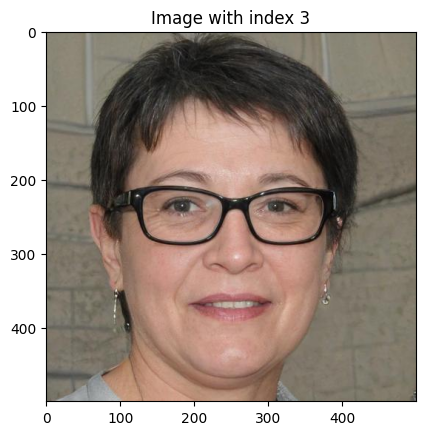

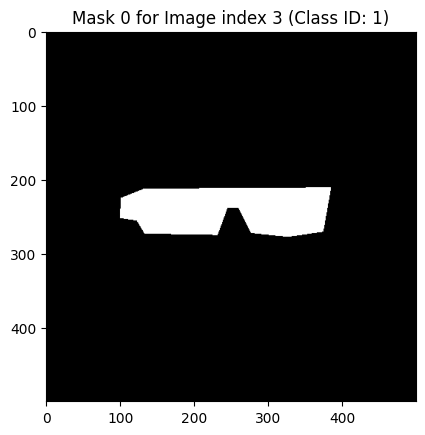

In [50]:
import matplotlib.pyplot as plt

# Visualize an image and its mask
image = dataset.load_image(image_index)
mask, class_ids = dataset.load_mask(image_index)

# Show the image
plt.imshow(image)
plt.title(f"Image with index {image_index}")
plt.show()

# Show the masks
for i in range(mask.shape[-1]):
    plt.imshow(mask[:, :, i], cmap='gray')
    plt.title(f"Mask {i} for Image index {image_index} (Class ID: {class_ids[i]})")
    plt.show()


In [55]:
# Import the model
from mrcnn.model import MaskRCNN

# Create a new Mask R-CNN model in training mode
model = MaskRCNN(mode="inference", config=config, model_dir="./logs")

# Load pre-trained weights (exclude layers that don't match our classes)
model.load_weights("mask_rcnn_coco.h5", by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])


NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Got a model or layer Conv2D with weights [<KerasVariable shape=(7, 7, 3, 64), dtype=float32, path=conv1/kernel>, <KerasVariable shape=(64,), dtype=float32, path=conv1/bias>]

In [13]:
import os
# Prepare the training dataset (80% of the data)
train_dataset = DroneDataset()
train_dataset.load_drone(dataset_dir="dataset", subset="train")
train_dataset.prepare()

# Prepare the validation dataset (20% of the data)
val_dataset = DroneDataset()
val_dataset.load_drone(dataset_dir="dataset", subset="val")
val_dataset.prepare()


In [ ]:
model.train(train_dataset, val_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')
model.keras_model.save_weights("model.h5")


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs\drone_detection20241107T2339\mask_rcnn_drone_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# Print available devices
print(device_lib.list_local_devices())


In [14]:
print("Model Configuration:")
config.display()


Model Configuration:

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

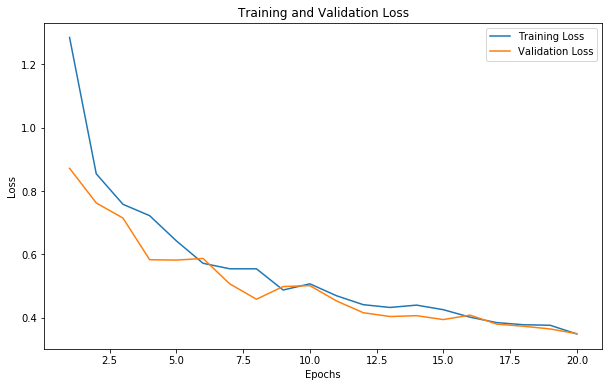

In [15]:
import matplotlib.pyplot as plt

# Données des époques
epochs = range(1, 21)

# Pertes d'entraînement et de validation
loss = [1.2853, 0.8544, 0.7581, 0.7221, 0.6426, 0.5717, 0.5543, 0.5542, 0.4872, 0.5068, 0.4691, 0.4409, 0.4321, 0.4395, 0.4250, 0.4014, 0.3842, 0.3775, 0.3758, 0.3483]
val_loss = [0.8718, 0.7624, 0.7146, 0.5829, 0.5818, 0.5869, 0.5067, 0.4581, 0.4982, 0.5011, 0.4527, 0.4155, 0.4035, 0.4061, 0.3938, 0.4079, 0.3794, 0.3727, 0.3642, 0.3492]

# Tracer les courbes de pertes
plt.figure(figsize=(10, 6))  
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [16]:
import tensorflow as tf
from mrcnn.model import MaskRCNN

# Initialiser une liste pour stocker les modèles
models = []

# Définir la structure de ton modèle
def get_model():
    model = MaskRCNN(mode="training", config=config, model_dir="logs")
    return model

# Charger les poids pour chaque époque
for epoch in range(1, 21):
    model_path = f'logs/drone_detection20241018T0748/mask_rcnn_drone_detection_{epoch:04d}.h5'
    model = get_model()
    model.load_weights(model_path, by_name=True)  
    models.append(model)


Re-starting from epoch 1
Re-starting from epoch 2
Re-starting from epoch 3
Re-starting from epoch 4
Re-starting from epoch 5
Re-starting from epoch 6
Re-starting from epoch 7
Re-starting from epoch 8
Re-starting from epoch 9
Re-starting from epoch 10
Re-starting from epoch 11
Re-starting from epoch 12
Re-starting from epoch 13
Re-starting from epoch 14
Re-starting from epoch 15
Re-starting from epoch 16
Re-starting from epoch 17
Re-starting from epoch 18
Re-starting from epoch 19
Re-starting from epoch 20


In [17]:
import numpy as np
from tqdm import tqdm

def evaluer_drone_model(model, dataset, config):
    """
    Évalue le modèle Mask R-CNN sur le DroneDataset
    """
    print("Début de l'évaluation...")
    print(f"Nombre d'images dans le dataset: {len(dataset.image_ids)}")
    
    # Initialiser la matrice de confusion
    num_classes = len(config.CLASS_NAMES)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    # Pour chaque image dans le dataset
    for image_id in tqdm(dataset.image_ids):
        # Charger l'image
        image = dataset.load_image(image_id)
        if image is None:
            print(f"Erreur: Impossible de charger l'image {image_id}")
            continue
            
        # Charger les masques et classes de vérité terrain
        gt_masks, gt_class_ids = dataset.load_mask(image_id)
        if gt_masks is None or len(gt_class_ids) == 0:
            print(f"Attention: Pas de masques trouvés pour l'image {image_id}")
            continue
            
        print(f"\nImage {image_id}:")
        print(f"Classes vérité terrain: {gt_class_ids}")
        
        # Faire les prédictions
        # Assurez-vous que la taille du batch est 1 pour chaque image dans l'évaluation
        config.BATCH_SIZE = 1
        results = model.detect([image], verbose=0)[0]
        pred_class_ids = results['class_ids']
        pred_masks = results['masks']
        scores = results['scores']
        
        print(f"Classes prédites: {pred_class_ids}")
        print(f"Scores: {scores}")
        
        # Pour chaque prédiction, trouver la meilleure correspondance
        for i, pred_class in enumerate(pred_class_ids):
            best_iou = 0
            best_gt_idx = -1
            
            # Comparer avec chaque masque de vérité terrain
            for j, gt_class in enumerate(gt_class_ids):
                pred_mask = pred_masks[:, :, i]
                gt_mask = gt_masks[:, :, j]
                
                # Calculer IoU
                iou = calculate_iou(pred_mask, gt_mask)
                if iou > best_iou and iou >= 0.5:  # Seuil IoU de 0.5
                    best_iou = iou
                    best_gt_idx = j
            
            if best_gt_idx >= 0:
                # Ajouter à la matrice de confusion
                gt_class = gt_class_ids[best_gt_idx] - 1  # -1 car les classes commencent à 1
                pred_class = pred_class - 1
                confusion_matrix[gt_class, pred_class] += 1
                print(f"Match trouvé: Classe GT {gt_class+1} -> Pred {pred_class+1} (IoU: {best_iou:.3f})")
    
    return confusion_matrix

def calculate_iou(mask1, mask2):
    """
    Calcule l'Intersection over Union entre deux masques
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

def afficher_metriques(confusion_matrix, class_names):
    """
    Affiche les métriques pour chaque classe
    """
    print("\nMétriques par classe:")
    print("-" * 50)
    
    for i, class_name in enumerate(class_names):
        if confusion_matrix[i].sum() + confusion_matrix[:, i].sum() == 0:
            continue
            
        # Calculer précision et rappel
        true_positives = confusion_matrix[i, i]
        false_positives = confusion_matrix[:, i].sum() - true_positives
        false_negatives = confusion_matrix[i, :].sum() - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nClasse {class_name}:")
        print(f"Précision: {precision:.3f}")
        print(f"Rappel: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")




Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 20
Évaluation du modèle sur le dataset de validation...
Début de l'évaluation...
Nombre d'images dans le dataset: 245


  0%|                                                                                          | 0/245 [00:00<?, ?it/s]


Image 0:
Classes vérité terrain: [1 1 1 1 1 1]








  0%|▎                                                                                 | 1/245 [00:13<55:42, 13.70s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 1:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  1%|▋                                                                                 | 2/245 [00:21<42:09, 10.41s/it]


Image 2:
Classes vérité terrain: [1]


  1%|█                                                                                 | 3/245 [00:29<37:19,  9.25s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 3:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  2%|█▎                                                                                | 4/245 [00:37<35:01,  8.72s/it]


Image 4:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  2%|█▋                                                                                | 5/245 [00:45<34:00,  8.50s/it]


Image 5:
Classes vérité terrain: [1]


  2%|██                                                                                | 6/245 [00:54<34:03,  8.55s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 6:
Classes vérité terrain: [1]


  3%|██▎                                                                               | 7/245 [01:02<33:51,  8.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 7:
Classes vérité terrain: [1]


  3%|██▋                                                                               | 8/245 [01:12<35:18,  8.94s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 8:
Classes vérité terrain: [1 1]


  4%|███                                                                               | 9/245 [01:20<33:56,  8.63s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 9:
Classes vérité terrain: [1]


  4%|███▎                                                                             | 10/245 [01:29<34:01,  8.69s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 10:
Classes vérité terrain: [1]


  4%|███▋                                                                             | 11/245 [01:37<33:38,  8.63s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 11:
Classes vérité terrain: [1]


  5%|███▉                                                                             | 12/245 [01:45<32:48,  8.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 12:
Classes vérité terrain: [1]


  5%|████▎                                                                            | 13/245 [01:53<32:05,  8.30s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 13:
Classes vérité terrain: [1]


  6%|████▋                                                                            | 14/245 [02:01<31:41,  8.23s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 14:
Classes vérité terrain: [1]


  6%|████▉                                                                            | 15/245 [02:10<31:39,  8.26s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 15:
Classes vérité terrain: [1]


  7%|█████▎                                                                           | 16/245 [02:18<31:38,  8.29s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 16:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  7%|█████▌                                                                           | 17/245 [02:27<31:51,  8.39s/it]


Image 17:
Classes vérité terrain: [1]


  7%|█████▉                                                                           | 18/245 [02:35<31:20,  8.28s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 18:
Classes vérité terrain: [1]


  8%|██████▎                                                                          | 19/245 [02:43<30:59,  8.23s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 19:
Classes vérité terrain: [1]


  8%|██████▌                                                                          | 20/245 [02:51<30:29,  8.13s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 20:
Classes vérité terrain: [1 1]


  9%|██████▉                                                                          | 21/245 [02:59<30:12,  8.09s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 21:
Classes vérité terrain: [1]


  9%|███████▎                                                                         | 22/245 [03:07<29:52,  8.04s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 22:
Classes vérité terrain: [1]


  9%|███████▌                                                                         | 23/245 [03:17<31:55,  8.63s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 23:
Classes vérité terrain: [1]


 10%|███████▉                                                                         | 24/245 [03:26<32:46,  8.90s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 24:
Classes vérité terrain: [1]


 10%|████████▎                                                                        | 25/245 [03:36<33:27,  9.12s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 25:
Classes vérité terrain: [1]


 11%|████████▌                                                                        | 26/245 [03:44<32:13,  8.83s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 26:
Classes vérité terrain: [1]


 11%|████████▉                                                                        | 27/245 [03:52<31:25,  8.65s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 27:
Classes vérité terrain: [1]


 11%|█████████▎                                                                       | 28/245 [04:02<32:01,  8.85s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 28:
Classes vérité terrain: [1 1]


 12%|█████████▌                                                                       | 29/245 [04:10<31:47,  8.83s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 29:
Classes vérité terrain: [1]


 12%|█████████▉                                                                       | 30/245 [04:19<31:08,  8.69s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 30:
Classes vérité terrain: [1]


 13%|██████████▏                                                                      | 31/245 [04:27<30:53,  8.66s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 31:
Classes vérité terrain: [1]


 13%|██████████▌                                                                      | 32/245 [04:36<30:16,  8.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 32:
Classes vérité terrain: [1]


 13%|██████████▉                                                                      | 33/245 [04:44<29:40,  8.40s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 33:
Classes vérité terrain: [1]


 14%|███████████▏                                                                     | 34/245 [04:52<29:26,  8.37s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 34:
Classes vérité terrain: [1]


 14%|███████████▌                                                                     | 35/245 [05:00<29:15,  8.36s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 35:
Classes vérité terrain: [1]


 15%|███████████▉                                                                     | 36/245 [05:10<30:10,  8.66s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 36:
Classes vérité terrain: [1]


 15%|████████████▏                                                                    | 37/245 [05:18<29:37,  8.55s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 37:
Classes vérité terrain: [1]


 16%|████████████▌                                                                    | 38/245 [05:26<29:18,  8.50s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 38:
Classes vérité terrain: [1]


 16%|████████████▉                                                                    | 39/245 [05:36<30:03,  8.75s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 39:
Classes vérité terrain: [1]


 16%|█████████████▏                                                                   | 40/245 [05:47<32:01,  9.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 40:
Classes vérité terrain: [1]


 17%|█████████████▌                                                                   | 41/245 [05:58<33:42,  9.91s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 41:
Classes vérité terrain: [1]


 17%|█████████████▉                                                                   | 42/245 [06:06<32:19,  9.55s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 42:
Classes vérité terrain: [1]


 18%|██████████████▏                                                                  | 43/245 [06:15<31:07,  9.25s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 43:
Classes vérité terrain: [1]


 18%|██████████████▌                                                                  | 44/245 [06:25<31:46,  9.49s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 44:
Classes vérité terrain: [1]


 18%|██████████████▉                                                                  | 45/245 [06:34<31:00,  9.30s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 45:
Classes vérité terrain: [1]


 19%|███████████████▏                                                                 | 46/245 [06:42<29:55,  9.02s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 46:
Classes vérité terrain: [1]


 19%|███████████████▌                                                                 | 47/245 [06:50<28:58,  8.78s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 47:
Classes vérité terrain: [1]


 20%|███████████████▊                                                                 | 48/245 [06:59<28:25,  8.66s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 48:
Classes vérité terrain: [1]


 20%|████████████████▏                                                                | 49/245 [07:09<29:31,  9.04s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 49:
Classes vérité terrain: [1]


 20%|████████████████▌                                                                | 50/245 [07:20<31:23,  9.66s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 50:
Classes vérité terrain: [1]


 21%|████████████████▊                                                                | 51/245 [07:30<32:04,  9.92s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 51:
Classes vérité terrain: [1]


 21%|█████████████████▏                                                               | 52/245 [07:40<31:14,  9.71s/it]

Classes prédites: [1 1]
Scores: [1. 1.]

Image 52:
Classes vérité terrain: [1]


 22%|█████████████████▌                                                               | 53/245 [07:48<29:42,  9.28s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 53:
Classes vérité terrain: [1]


 22%|█████████████████▊                                                               | 54/245 [07:56<28:36,  8.99s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 54:
Classes vérité terrain: [1]


 22%|██████████████████▏                                                              | 55/245 [08:04<27:48,  8.78s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 55:
Classes vérité terrain: [1]


 23%|██████████████████▌                                                              | 56/245 [08:13<27:21,  8.68s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 56:
Classes vérité terrain: [1]


 23%|██████████████████▊                                                              | 57/245 [08:22<27:22,  8.74s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 57:
Classes vérité terrain: [1]


 24%|███████████████████▏                                                             | 58/245 [08:30<27:09,  8.72s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 58:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 24%|███████████████████▌                                                             | 59/245 [08:41<28:27,  9.18s/it]


Image 59:
Classes vérité terrain: [1]


 24%|███████████████████▊                                                             | 60/245 [08:49<27:38,  8.97s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 60:
Classes vérité terrain: [1]


 25%|████████████████████▏                                                            | 61/245 [08:58<27:02,  8.82s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 61:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 25%|████████████████████▍                                                            | 62/245 [09:07<27:20,  8.96s/it]


Image 62:
Classes vérité terrain: [1]


 26%|████████████████████▊                                                            | 63/245 [09:16<26:54,  8.87s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 63:
Classes vérité terrain: [1]


 26%|█████████████████████▏                                                           | 64/245 [09:24<26:25,  8.76s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 64:
Classes vérité terrain: [1]


 27%|█████████████████████▍                                                           | 65/245 [09:32<25:43,  8.58s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 65:
Classes vérité terrain: [1]


 27%|█████████████████████▊                                                           | 66/245 [09:40<25:13,  8.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 66:
Classes vérité terrain: [1]


 27%|██████████████████████▏                                                          | 67/245 [09:49<24:46,  8.35s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 67:
Classes vérité terrain: [1]


 28%|██████████████████████▍                                                          | 68/245 [09:57<24:36,  8.34s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 68:
Classes vérité terrain: [1]


 28%|██████████████████████▊                                                          | 69/245 [10:05<24:19,  8.29s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 69:
Classes vérité terrain: [1]


 29%|███████████████████████▏                                                         | 70/245 [10:14<24:27,  8.39s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 70:
Classes vérité terrain: [1]


 29%|███████████████████████▍                                                         | 71/245 [10:22<24:18,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 71:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 29%|███████████████████████▊                                                         | 72/245 [10:36<29:22, 10.19s/it]


Image 72:
Classes vérité terrain: [1]


 30%|████████████████████████▏                                                        | 73/245 [10:45<27:43,  9.67s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 73:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 30%|████████████████████████▍                                                        | 74/245 [10:58<30:33, 10.72s/it]


Image 74:
Classes vérité terrain: [1]


 31%|████████████████████████▊                                                        | 75/245 [11:08<29:38, 10.46s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 75:
Classes vérité terrain: [1]


 31%|█████████████████████████▏                                                       | 76/245 [11:18<29:11, 10.36s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 76:
Classes vérité terrain: [1]


 31%|█████████████████████████▍                                                       | 77/245 [11:27<27:43,  9.90s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 77:
Classes vérité terrain: [1]


 32%|█████████████████████████▊                                                       | 78/245 [11:35<26:18,  9.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 78:
Classes vérité terrain: [1]


 32%|██████████████████████████                                                       | 79/245 [11:43<25:02,  9.05s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 79:
Classes vérité terrain: [1]


 33%|██████████████████████████▍                                                      | 80/245 [11:52<24:09,  8.79s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 80:
Classes vérité terrain: [1]


 33%|██████████████████████████▊                                                      | 81/245 [12:00<23:36,  8.64s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 81:
Classes vérité terrain: [1]


 33%|███████████████████████████                                                      | 82/245 [12:08<23:15,  8.56s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 82:
Classes vérité terrain: [1]


 34%|███████████████████████████▍                                                     | 83/245 [12:17<23:02,  8.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 83:
Classes vérité terrain: [1]


 34%|███████████████████████████▊                                                     | 84/245 [12:25<22:34,  8.41s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 84:
Classes vérité terrain: [1]


 35%|████████████████████████████                                                     | 85/245 [12:33<22:20,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 85:
Classes vérité terrain: [1]


 35%|████████████████████████████▍                                                    | 86/245 [12:42<22:22,  8.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 86:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 36%|████████████████████████████▊                                                    | 87/245 [12:52<23:40,  8.99s/it]


Image 87:
Classes vérité terrain: [1]


 36%|█████████████████████████████                                                    | 88/245 [13:00<22:49,  8.72s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 88:
Classes vérité terrain: [1]


 36%|█████████████████████████████▍                                                   | 89/245 [13:08<22:14,  8.56s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 89:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 37%|█████████████████████████████▊                                                   | 90/245 [13:25<28:45, 11.14s/it]


Image 90:
Classes vérité terrain: [1]


 37%|██████████████████████████████                                                   | 91/245 [13:35<27:19, 10.65s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 91:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 38%|██████████████████████████████▍                                                  | 92/245 [13:51<31:20, 12.29s/it]


Image 92:
Classes vérité terrain: [1]


 38%|██████████████████████████████▋                                                  | 93/245 [14:00<28:37, 11.30s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 93:
Classes vérité terrain: [1]


 38%|███████████████████████████████                                                  | 94/245 [14:09<26:22, 10.48s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 94:
Classes vérité terrain: [1]


 39%|███████████████████████████████▍                                                 | 95/245 [14:17<24:56,  9.98s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 95:
Classes vérité terrain: [1]


 39%|███████████████████████████████▋                                                 | 96/245 [14:26<23:37,  9.51s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 96:
Classes vérité terrain: [1]


 40%|████████████████████████████████                                                 | 97/245 [14:34<22:47,  9.24s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 97:
Classes vérité terrain: [1]


 40%|████████████████████████████████▍                                                | 98/245 [14:43<22:16,  9.09s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 98:
Classes vérité terrain: [1]


 40%|████████████████████████████████▋                                                | 99/245 [14:52<22:10,  9.12s/it]

Classes prédites: [1 1 1]
Scores: [1. 1. 1.]

Image 99:
Classes vérité terrain: [1]


 41%|████████████████████████████████▋                                               | 100/245 [15:01<21:26,  8.87s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 100:
Classes vérité terrain: [1]


 41%|████████████████████████████████▉                                               | 101/245 [15:09<20:55,  8.72s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 101:
Classes vérité terrain: [1]


 42%|█████████████████████████████████▎                                              | 102/245 [15:17<20:36,  8.64s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 102:
Classes vérité terrain: [1]


 42%|█████████████████████████████████▋                                              | 103/245 [15:26<20:15,  8.56s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 103:
Classes vérité terrain: [1]


 42%|█████████████████████████████████▉                                              | 104/245 [15:35<20:20,  8.66s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 104:
Classes vérité terrain: [1]


 43%|██████████████████████████████████▎                                             | 105/245 [15:43<20:01,  8.59s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 105:
Classes vérité terrain: [1]


 43%|██████████████████████████████████▌                                             | 106/245 [15:52<19:51,  8.57s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 106:
Classes vérité terrain: [1]


 44%|██████████████████████████████████▉                                             | 107/245 [16:00<19:33,  8.50s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Attention: Pas de masques trouvés pour l'image 107
Attention: Pas de masques trouvés pour l'image 108

Image 109:
Classes vérité terrain: [1]


 45%|███████████████████████████████████▉                                            | 110/245 [16:09<11:57,  5.31s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 110:
Classes vérité terrain: [1]


 45%|████████████████████████████████████▏                                           | 111/245 [16:17<13:25,  6.01s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 111:
Classes vérité terrain: [1]


 46%|████████████████████████████████████▌                                           | 112/245 [16:25<14:29,  6.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 112:
Classes vérité terrain: [1]


 46%|████████████████████████████████████▉                                           | 113/245 [16:34<15:20,  6.98s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 113:
Classes vérité terrain: [1]


 47%|█████████████████████████████████████▏                                          | 114/245 [16:42<16:01,  7.34s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 114:
Classes vérité terrain: [1]


 47%|█████████████████████████████████████▌                                          | 115/245 [16:50<16:27,  7.60s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 115:
Classes vérité terrain: [1]


 47%|█████████████████████████████████████▉                                          | 116/245 [16:59<16:44,  7.79s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 116:
Classes vérité terrain: [1]


 48%|██████████████████████████████████████▏                                         | 117/245 [17:07<16:56,  7.94s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 117:
Classes vérité terrain: [1]


 48%|██████████████████████████████████████▌                                         | 118/245 [17:15<17:04,  8.07s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 118:
Classes vérité terrain: [1]


 49%|██████████████████████████████████████▊                                         | 119/245 [17:24<17:15,  8.22s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 119:
Classes vérité terrain: [1]


 49%|███████████████████████████████████████▏                                        | 120/245 [17:33<17:27,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 120:
Classes vérité terrain: [1]


 49%|███████████████████████████████████████▌                                        | 121/245 [17:41<17:19,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 121:
Classes vérité terrain: [1]


 50%|███████████████████████████████████████▊                                        | 122/245 [17:50<17:12,  8.40s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 122:
Classes vérité terrain: [1]


 50%|████████████████████████████████████████▏                                       | 123/245 [17:58<17:02,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 123:
Classes vérité terrain: [1]


 51%|████████████████████████████████████████▍                                       | 124/245 [18:06<16:52,  8.37s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 124:
Classes vérité terrain: [1]


 51%|████████████████████████████████████████▊                                       | 125/245 [18:15<16:45,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 125:
Classes vérité terrain: [1]


 51%|█████████████████████████████████████████▏                                      | 126/245 [18:23<16:52,  8.51s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 126:
Classes vérité terrain: [1]


 52%|█████████████████████████████████████████▍                                      | 127/245 [18:32<16:36,  8.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 127:
Classes vérité terrain: [1]


 52%|█████████████████████████████████████████▊                                      | 128/245 [18:40<16:24,  8.41s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 128:
Classes vérité terrain: [1]


 53%|██████████████████████████████████████████                                      | 129/245 [18:48<16:16,  8.42s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 129:
Classes vérité terrain: [1]


 53%|██████████████████████████████████████████▍                                     | 130/245 [18:57<16:05,  8.40s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 130:
Classes vérité terrain: [1]


 53%|██████████████████████████████████████████▊                                     | 131/245 [19:05<15:56,  8.39s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 131:
Classes vérité terrain: [1]


 54%|███████████████████████████████████████████                                     | 132/245 [19:14<15:59,  8.49s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 132:
Classes vérité terrain: [1]


 54%|███████████████████████████████████████████▍                                    | 133/245 [19:22<15:43,  8.42s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 133:
Classes vérité terrain: [1]


 55%|███████████████████████████████████████████▊                                    | 134/245 [19:31<15:38,  8.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 134:
Classes vérité terrain: [1]


 55%|████████████████████████████████████████████                                    | 135/245 [19:39<15:29,  8.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 135:
Classes vérité terrain: [1]


 56%|████████████████████████████████████████████▍                                   | 136/245 [19:48<15:22,  8.46s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 136:
Classes vérité terrain: [1]


 56%|████████████████████████████████████████████▋                                   | 137/245 [19:56<15:21,  8.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 137:
Classes vérité terrain: [1]


 56%|█████████████████████████████████████████████                                   | 138/245 [20:05<15:12,  8.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 138:
Classes vérité terrain: [1]


 57%|█████████████████████████████████████████████▍                                  | 139/245 [20:15<15:56,  9.02s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 139:
Classes vérité terrain: [1]


 57%|█████████████████████████████████████████████▋                                  | 140/245 [20:25<16:24,  9.37s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 140:
Classes vérité terrain: [1]


 58%|██████████████████████████████████████████████                                  | 141/245 [20:35<16:23,  9.46s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 141:
Classes vérité terrain: [1]


 58%|██████████████████████████████████████████████▎                                 | 142/245 [20:43<15:39,  9.12s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 142:
Classes vérité terrain: [1]


 58%|██████████████████████████████████████████████▋                                 | 143/245 [20:52<15:12,  8.95s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 143:
Classes vérité terrain: [1]


 59%|███████████████████████████████████████████████                                 | 144/245 [21:00<14:50,  8.82s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 144:
Classes vérité terrain: [1]


 59%|███████████████████████████████████████████████▎                                | 145/245 [21:09<14:28,  8.69s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 145:
Classes vérité terrain: [1]


 60%|███████████████████████████████████████████████▋                                | 146/245 [21:17<14:10,  8.59s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 146:
Classes vérité terrain: [1]


 60%|████████████████████████████████████████████████                                | 147/245 [21:25<13:56,  8.54s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 147:
Classes vérité terrain: [1]


 60%|████████████████████████████████████████████████▎                               | 148/245 [21:34<13:46,  8.52s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 148:
Classes vérité terrain: [1]


 61%|████████████████████████████████████████████████▋                               | 149/245 [21:42<13:36,  8.50s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 149:
Classes vérité terrain: [1]


 61%|████████████████████████████████████████████████▉                               | 150/245 [21:51<13:25,  8.47s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 150:
Classes vérité terrain: [1]


 62%|█████████████████████████████████████████████████▎                              | 151/245 [21:59<13:14,  8.46s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 151:
Classes vérité terrain: [1]


 62%|█████████████████████████████████████████████████▋                              | 152/245 [22:08<13:04,  8.43s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 152:
Classes vérité terrain: [1]


 62%|█████████████████████████████████████████████████▉                              | 153/245 [22:16<13:01,  8.49s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 153:
Classes vérité terrain: [1]


 63%|██████████████████████████████████████████████████▎                             | 154/245 [22:25<12:56,  8.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 154:
Classes vérité terrain: [1]


 63%|██████████████████████████████████████████████████▌                             | 155/245 [22:34<12:55,  8.61s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 155:
Classes vérité terrain: [1]


 64%|██████████████████████████████████████████████████▉                             | 156/245 [22:42<12:47,  8.63s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 156:
Classes vérité terrain: [1]


 64%|███████████████████████████████████████████████████▎                            | 157/245 [22:51<12:40,  8.64s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 157:
Classes vérité terrain: [1]


 64%|███████████████████████████████████████████████████▌                            | 158/245 [22:59<12:23,  8.55s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 158:
Classes vérité terrain: [1]


 65%|███████████████████████████████████████████████████▉                            | 159/245 [23:08<12:10,  8.50s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 159:
Classes vérité terrain: [1]


 65%|████████████████████████████████████████████████████▏                           | 160/245 [23:16<11:59,  8.47s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 160:
Classes vérité terrain: [1]


 66%|████████████████████████████████████████████████████▌                           | 161/245 [23:25<11:51,  8.47s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 161:
Classes vérité terrain: [1]


 66%|████████████████████████████████████████████████████▉                           | 162/245 [23:33<11:40,  8.44s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 162:
Classes vérité terrain: [1]


 67%|█████████████████████████████████████████████████████▏                          | 163/245 [23:41<11:28,  8.39s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 163:
Classes vérité terrain: [1]


 67%|█████████████████████████████████████████████████████▌                          | 164/245 [23:50<11:22,  8.42s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 164:
Classes vérité terrain: [1]


 67%|█████████████████████████████████████████████████████▉                          | 165/245 [23:58<11:12,  8.41s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 165:
Classes vérité terrain: [1]


 68%|██████████████████████████████████████████████████████▏                         | 166/245 [24:06<11:01,  8.37s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 166:
Classes vérité terrain: [1]


 68%|██████████████████████████████████████████████████████▌                         | 167/245 [24:15<10:52,  8.36s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 167:
Classes vérité terrain: [1]


 69%|██████████████████████████████████████████████████████▊                         | 168/245 [24:23<10:45,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 168:
Classes vérité terrain: [1]


 69%|███████████████████████████████████████████████████████▏                        | 169/245 [24:32<10:38,  8.40s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 169:
Classes vérité terrain: [1]


 69%|███████████████████████████████████████████████████████▌                        | 170/245 [24:40<10:27,  8.36s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 170:
Classes vérité terrain: [1]


 70%|███████████████████████████████████████████████████████▊                        | 171/245 [24:48<10:17,  8.34s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 171:
Classes vérité terrain: [1]


 70%|████████████████████████████████████████████████████████▏                       | 172/245 [24:56<10:07,  8.32s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 172:
Classes vérité terrain: [1]


 71%|████████████████████████████████████████████████████████▍                       | 173/245 [25:05<09:58,  8.32s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 173:
Classes vérité terrain: [1]


 71%|████████████████████████████████████████████████████████▊                       | 174/245 [25:13<09:49,  8.31s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 174:
Classes vérité terrain: [1]


 71%|█████████████████████████████████████████████████████████▏                      | 175/245 [25:22<09:46,  8.38s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 175:
Classes vérité terrain: [1]


 72%|█████████████████████████████████████████████████████████▍                      | 176/245 [25:30<09:40,  8.41s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 176:
Classes vérité terrain: [1]


 72%|█████████████████████████████████████████████████████████▊                      | 177/245 [25:38<09:28,  8.37s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 177:
Classes vérité terrain: [1]


 73%|██████████████████████████████████████████████████████████                      | 178/245 [25:47<09:18,  8.33s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 178:
Classes vérité terrain: [1]


 73%|██████████████████████████████████████████████████████████▍                     | 179/245 [25:55<09:07,  8.29s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 179:
Classes vérité terrain: [1]


 73%|██████████████████████████████████████████████████████████▊                     | 180/245 [26:03<08:59,  8.31s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 180:
Classes vérité terrain: [1]


 74%|███████████████████████████████████████████████████████████                     | 181/245 [26:11<08:50,  8.29s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 181:
Classes vérité terrain: [1]


 74%|███████████████████████████████████████████████████████████▍                    | 182/245 [26:20<08:52,  8.45s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 182:
Classes vérité terrain: [1]


 77%|█████████████████████████████████████████████████████████████▋                  | 189/245 [26:29<02:12,  2.36s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Attention: Pas de masques trouvés pour l'image 183
Attention: Pas de masques trouvés pour l'image 184
Attention: Pas de masques trouvés pour l'image 185
Attention: Pas de masques trouvés pour l'image 186
Attention: Pas de masques trouvés pour l'image 187
Attention: Pas de masques trouvés pour l'image 188
Attention: Pas de masques trouvés pour l'image 189
Attention: Pas de masques trouvés pour l'image 190

Image 191:
Classes vérité terrain: [1]


 78%|██████████████████████████████████████████████████████████████▋                 | 192/245 [26:37<02:12,  2.50s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 192:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 193:
Classes vérité terrain: [1]


 78%|██████████████████████████████████████████████████████████████▋                 | 192/245 [26:48<02:12,  2.50s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 79%|███████████████████████████████████████████████████████████████▎                | 194/245 [26:54<03:25,  4.03s/it]


Image 194:
Classes vérité terrain: [1]


 80%|███████████████████████████████████████████████████████████████▋                | 195/245 [27:03<03:53,  4.66s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 195:
Classes vérité terrain: [1]


 80%|████████████████████████████████████████████████████████████████                | 196/245 [27:11<04:20,  5.33s/it]

Classes prédites: [1 1 1]
Scores: [1. 1. 1.]

Image 196:
Classes vérité terrain: [1]


 80%|████████████████████████████████████████████████████████████████▎               | 197/245 [27:20<04:51,  6.08s/it]

Classes prédites: [1 1 1]
Scores: [1. 1. 1.]

Image 197:
Classes vérité terrain: [1]


 81%|████████████████████████████████████████████████████████████████▋               | 198/245 [27:30<05:29,  7.00s/it]

Classes prédites: [1 1 1]
Scores: [1. 1. 1.]

Image 198:
Classes vérité terrain: [1]


 81%|████████████████████████████████████████████████████████████████▉               | 199/245 [27:39<05:36,  7.32s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 199:
Classes vérité terrain: [1 1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 82%|█████████████████████████████████████████████████████████████████▎              | 200/245 [27:54<07:03,  9.40s/it]


Image 200:
Classes vérité terrain: [1]


 82%|█████████████████████████████████████████████████████████████████▋              | 201/245 [28:03<06:46,  9.23s/it]

Classes prédites: [1 1 1]
Scores: [1. 1. 1.]

Image 201:
Classes vérité terrain: [1]


 82%|█████████████████████████████████████████████████████████████████▉              | 202/245 [28:11<06:23,  8.92s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Attention: Pas de masques trouvés pour l'image 202

Image 203:
Classes vérité terrain: [1]


 83%|██████████████████████████████████████████████████████████████████▌             | 204/245 [28:20<04:48,  7.05s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 204:
Classes vérité terrain: [1]


 84%|██████████████████████████████████████████████████████████████████▉             | 205/245 [28:29<04:57,  7.43s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 205:
Classes vérité terrain: [1]


 84%|███████████████████████████████████████████████████████████████████▎            | 206/245 [28:38<05:01,  7.74s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 206:
Classes vérité terrain: [1]


 84%|███████████████████████████████████████████████████████████████████▌            | 207/245 [28:46<05:02,  7.96s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 207:
Classes vérité terrain: [1]


 85%|███████████████████████████████████████████████████████████████████▉            | 208/245 [28:55<05:01,  8.16s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 208:
Classes vérité terrain: [1]


 85%|████████████████████████████████████████████████████████████████████▏           | 209/245 [29:04<04:58,  8.28s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 209:
Classes vérité terrain: [1]


 86%|████████████████████████████████████████████████████████████████████▌           | 210/245 [29:12<04:52,  8.36s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 210:
Classes vérité terrain: [1]


 86%|████████████████████████████████████████████████████████████████████▉           | 211/245 [29:21<04:47,  8.46s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 211:
Classes vérité terrain: [1]
Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 87%|█████████████████████████████████████████████████████████████████████▏          | 212/245 [29:29<04:40,  8.50s/it]

Attention: Pas de masques trouvés pour l'image 212
Attention: Pas de masques trouvés pour l'image 213

Image 214:
Classes vérité terrain: [1]


 88%|██████████████████████████████████████████████████████████████████████▏         | 215/245 [29:38<02:40,  5.33s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 215:
Classes vérité terrain: [1]


 88%|██████████████████████████████████████████████████████████████████████▌         | 216/245 [29:46<02:53,  5.98s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 216:
Classes vérité terrain: [1]


 89%|██████████████████████████████████████████████████████████████████████▊         | 217/245 [29:55<03:05,  6.62s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 217:
Classes vérité terrain: [1]


 89%|███████████████████████████████████████████████████████████████████████▏        | 218/245 [30:04<03:13,  7.18s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 218:
Classes vérité terrain: [1]


 89%|███████████████████████████████████████████████████████████████████████▌        | 219/245 [30:13<03:17,  7.59s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 219:
Classes vérité terrain: [1]


 90%|███████████████████████████████████████████████████████████████████████▊        | 220/245 [30:22<03:21,  8.05s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 220:
Classes vérité terrain: [1]


 90%|████████████████████████████████████████████████████████████████████████▏       | 221/245 [30:30<03:15,  8.16s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 221:
Classes vérité terrain: [1]


 91%|████████████████████████████████████████████████████████████████████████▍       | 222/245 [30:39<03:09,  8.24s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 222:
Classes vérité terrain: [1]


 91%|████████████████████████████████████████████████████████████████████████▊       | 223/245 [30:47<03:01,  8.26s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 223:
Classes vérité terrain: [1]


 91%|█████████████████████████████████████████████████████████████████████████▏      | 224/245 [30:56<02:54,  8.30s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 224:
Classes vérité terrain: [1]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 225/245 [31:04<02:49,  8.46s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 225:
Classes vérité terrain: [1]


 92%|█████████████████████████████████████████████████████████████████████████▊      | 226/245 [31:13<02:42,  8.57s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 226:
Classes vérité terrain: [1]


 93%|██████████████████████████████████████████████████████████████████████████      | 227/245 [31:22<02:33,  8.51s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 227:
Classes vérité terrain: [1]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 228/245 [31:30<02:24,  8.51s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 228:
Classes vérité terrain: [1]


 93%|██████████████████████████████████████████████████████████████████████████▊     | 229/245 [31:38<02:15,  8.48s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 229:
Classes vérité terrain: [1]


 94%|███████████████████████████████████████████████████████████████████████████     | 230/245 [31:47<02:07,  8.53s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 230:
Classes vérité terrain: [1]


 94%|███████████████████████████████████████████████████████████████████████████▍    | 231/245 [31:56<01:59,  8.54s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 231:
Classes vérité terrain: [1]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 232/245 [32:05<01:52,  8.64s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 232:
Classes vérité terrain: [1 1]


 95%|████████████████████████████████████████████████████████████████████████████    | 233/245 [32:13<01:43,  8.66s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 233:
Classes vérité terrain: [1 1]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 234/245 [32:22<01:35,  8.70s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 234:
Classes vérité terrain: [1 1]


 96%|████████████████████████████████████████████████████████████████████████████▋   | 235/245 [32:31<01:26,  8.68s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 235:
Classes vérité terrain: [1]


 96%|█████████████████████████████████████████████████████████████████████████████   | 236/245 [32:39<01:17,  8.63s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 236:
Classes vérité terrain: [1]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 237/245 [32:48<01:08,  8.62s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 237:
Classes vérité terrain: [1]


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 238/245 [32:56<01:00,  8.61s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 238:
Classes vérité terrain: [1]


 98%|██████████████████████████████████████████████████████████████████████████████  | 239/245 [33:05<00:51,  8.60s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 239:
Classes vérité terrain: [1]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 240/245 [33:14<00:43,  8.62s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 240:
Classes vérité terrain: [1]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 241/245 [33:22<00:34,  8.63s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 241:
Classes vérité terrain: [1]


 99%|███████████████████████████████████████████████████████████████████████████████ | 242/245 [33:31<00:25,  8.55s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 242:
Classes vérité terrain: [1]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 243/245 [33:39<00:17,  8.59s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 243:
Classes vérité terrain: [1]


100%|███████████████████████████████████████████████████████████████████████████████▋| 244/245 [33:48<00:08,  8.55s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Image 244:
Classes vérité terrain: [1]


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [33:56<00:00,  8.31s/it]

Classes prédites: [1 1 1 1 1 1 1 1 1 1 1 1]
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Matrice de confusion:
[[0 0]
 [0 0]]

Métriques par classe:
--------------------------------------------------


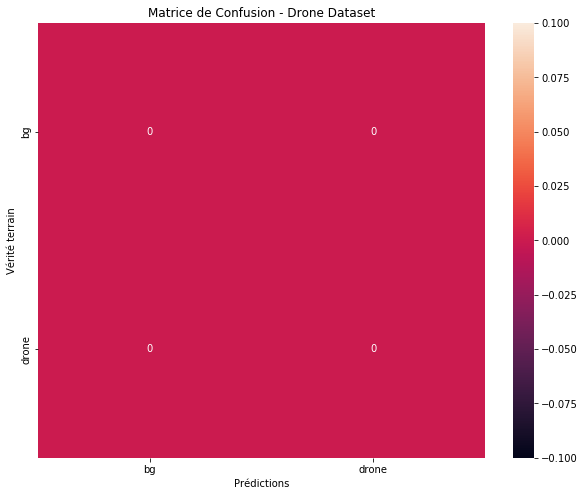

In [21]:
# 1. D'abord, importez les bibliothèques nécessaires
import numpy as np
from tqdm import tqdm

# Créer une instance du modèle en mode d'inférence
model = MaskRCNN(mode="inference", config=config, model_dir="./")

# Charger les poids du modèle (par exemple, ceux d'un modèle pré-entraîné)
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')
model.load_weights(model_path, by_name=True)

# 2. Évaluez votre modèle sur le dataset de validation
print("Évaluation du modèle sur le dataset de validation...")
confusion_mat = evaluer_drone_model(model, val_dataset, config)

# 3. Affichez la matrice de confusion
print("\nMatrice de confusion:")
print(confusion_mat)

# 4. Affichez les métriques détaillées
afficher_metriques(confusion_mat, config.CLASS_NAMES)

# 5. Visualisation avec seaborn (optionnel)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, 
            annot=True, 
            fmt='d',
            xticklabels=config.CLASS_NAMES,
            yticklabels=config.CLASS_NAMES)
plt.title('Matrice de Confusion - Drone Dataset')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.show()

In [20]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.9
    CLASS_NAMES = ['BG', 'drone']  # Background and drone

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 20


In [41]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def collect_predictions(model, dataset):
    y_true = []
    y_pred = []

    for image_id in tqdm(dataset.image_ids):
        image = dataset.load_image(image_id)
        gt_class_ids = dataset.load_mask(image_id)[1]  # Classes de vérité terrain

        results = model.detect([image], verbose=0)[0]
        pred_class_ids = results['class_ids']  # Classes prédites

        y_true.extend(gt_class_ids)
        y_pred.extend(pred_class_ids)

    return y_true, y_pred

# Utilisation de la fonction
y_true, y_pred = collect_predictions(model, val_dataset)

# Créer la matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=range(len(config.CLASS_NAMES)))

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=config.CLASS_NAMES, yticklabels=config.CLASS_NAMES)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.savefig('images/confusion_matrix.png')
plt.show()


  0%|                                                                                          | 0/245 [00:21<?, ?it/s]


InvalidArgumentError: Input to reshape is a tensor with 600 values, but the requested shape has 0
	 [[node mrcnn_detection/Reshape_1 (defined at c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'mrcnn_detection/Reshape_1':
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelapp.py", line 619, in start
    self.io_loop.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2053236bf96b>", line 20, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 2044, in build
    [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 820, in call
    [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 131, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 8115, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mrcnn.visualize import display_instances
from skimage.draw import polygon as draw_polygon

# Define the missing polygon_to_mask function
def polygon_to_mask(polygon, height, width):
    """Convert polygon points to binary mask."""
    poly_x = [p[0] for p in polygon]
    poly_y = [p[1] for p in polygon]
    rr, cc = draw_polygon(poly_y, poly_x, shape=(height, width))
    return rr, cc

def visualize_detections(model, dataset):
    # Loop through the images in the dataset
    for image_id in dataset.image_ids:
        # Load the image
        image = dataset.load_image(image_id)
        
        # Get the ground truth (optional, just to know if it has a drone or not)
        gt_mask, gt_class_id = dataset.load_mask(image_id)
        true_label = "Drone" if len(gt_class_id) > 0 else "No Drone"
        
        # Predict using the model
        if image.shape[0] != 1024 or image.shape[1] != 1024:
            print(f"Resizing image {image_id} for detection")
            image = cv2.resize(image, (1024, 1024))
        
        result = model.detect([image], verbose=0)[0]
        pred_class_ids = result['class_ids']
        pred_scores = result['scores']
        pred_masks = result['masks']
        pred_bboxes = result['rois']
        
        # Determine if a drone is detected
        predicted_label = "Drone" if len(pred_class_ids) > 0 else "No Drone"
        
        # Print out the detection result
        print(f"Image {image_id}: True Label: {true_label}, Predicted Label: {predicted_label}")
        
        # If a drone is detected, display the image with segmentation and bounding box
        if predicted_label == "Drone":
            print(f"Drone detected with score: {pred_scores[0]:.2f}")
            # Visualize the image with the predicted mask, bounding box, and class name
            display_instances(image, pred_bboxes, pred_masks, pred_class_ids,
                              dataset.class_names, pred_scores)
            plt.show()

# Test the function on the validation dataset
visualize_detections(model, val_dataset)

    


Resizing image 0 for detection


InvalidArgumentError: Input to reshape is a tensor with 600 values, but the requested shape has 0
	 [[node mrcnn_detection/Reshape_1 (defined at c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'mrcnn_detection/Reshape_1':
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelapp.py", line 619, in start
    self.io_loop.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2053236bf96b>", line 20, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 2044, in build
    [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 820, in call
    [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 131, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 8115, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [39]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Ensure you use the correct GPU count
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.9

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model = _dir, 'mask_rcnn_drone_detection_0020.h5')


# Assuming you have DroneDataset class defined as before

# Define the paths to your dataset directories
dataset_dir = 'dataset'

# Initialize the training dataset
dataset_train = DroneDataset()
dataset_train.load_drone(dataset_dir, 'train')
dataset_train.prepare()

# Initialize the validation dataset
dataset_val = DroneDataset()
dataset_val.load_drone(dataset_dir, 'val')
dataset_val.prepare()


# Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir="mask_rcnn_drone_detection_0020.h5")
print("Loading model weights...")
model.load_weights(model_path, by_name=True)
print("Model weights loaded.")


# Fine-tune the model with a lower learning rate
print("Starting fine-tuning...")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10,
            layers='all')
print("Fine-tuning finished.")

# Save the fine-tuned model weights
print("Saving fine-tuned weights...")
model.keras_model.save_weights("fine_tuned_model.h5")
print("Weights saved.")



SyntaxError: positional argument follows keyword argument (<ipython-input-39-890ad0820569>, line 16)

In [ ]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Utiliser le GPU pour l'entraînement
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.9
    CLASS_NAMES = ['BG', 'drone']  # Background and drone
    STEPS_PER_EPOCH = 100

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)

# Load the dataset
dataset_train = DroneDataset()
dataset_train.load_drone(dataset_dir="dataset", subset="train")
dataset_train.prepare()

dataset_val = DroneDataset()
dataset_val.load_drone(dataset_dir="dataset", subset="val")
dataset_val.prepare()

total_epochs = 30
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=total_epochs,
            layers='heads')

In [17]:
#fine tuning code
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Utiliser le GPU pour l'entraînement
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 0.4
    CLASS_NAMES = ['BG', 'drone']  # Background and drone
    STEPS_PER_EPOCH = 150
    VALIDATION_STEPS = 25


# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)

# Load the dataset
dataset_train = DroneDataset()
dataset_train.load_drone(dataset_dir="dataset", subset="train")
dataset_train.prepare()

dataset_val = DroneDataset()
dataset_val.load_drone(dataset_dir="dataset", subset="val")
dataset_val.prepare()

total_epochs = 30
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 100,
            epochs=total_epochs,
            layers='heads')

KeyboardInterrupt: 

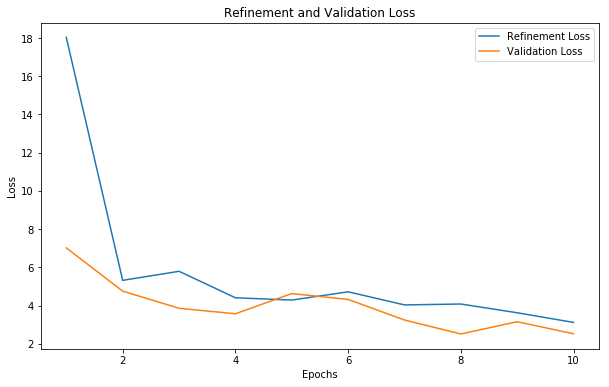

In [22]:
import matplotlib.pyplot as plt

# Données des époques
epochs = range(1, 11)

# Pertes d'entraînement et de validation
loss = [18.0295, 5.3188, 5.7917, 4.4059, 4.2870, 4.7180, 4.0324, 4.0793, 3.6217, 3.1154]
val_loss = [7.0165, 4.7544, 3.8562, 3.5684, 4.6263, 4.3181, 3.2419, 2.5117, 3.1529, 2.5203]

# Tracer les courbes de pertes
plt.figure(figsize=(10, 6))  
plt.plot(epochs, loss, label='Refinement Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Refinement and Validation Loss')
plt.legend()
plt.show()

